In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import time
import warnings
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from tqdm import tqdm


In [2]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=None, 
                 early_stopping=False, patience=50, tol=1e-4,
                 l1_penalty=0, l2_penalty=0):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size  # None means use all data (batch gradient descent)
        self.early_stopping = early_stopping
        self.patience = patience
        self.tol = tol
        self.l1_penalty = l1_penalty  # L1 regularization parameter (Lasso)
        self.l2_penalty = l2_penalty  # L2 regularization parameter (Ridge)
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.val_cost_history = []
        self.best_weights = None
        self.best_bias = None
        self.best_iteration = 0
        self.feature_names = None
        self.scaler_X = None
        self.scaler_y = None
    
    def _initialize_weights(self, n_features):
        """Initialize weights using Xavier/Glorot initialization"""
        limit = np.sqrt(6 / (n_features + 1))
        self.weights = np.random.uniform(-limit, limit, size=n_features)
        self.bias = 0
    
    def _get_batch_indices(self, n_samples, batch_size, shuffle=True):
        """Generate batch indices"""
        indices = np.arange(n_samples)
        if shuffle:
            np.random.shuffle(indices)
        
        for i in range(0, n_samples, batch_size):
            yield indices[i:i + batch_size]
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=True, feature_names=None):
        """
        Train the linear regression model using gradient descent
        
        Parameters:
        X: training features (numpy array)
        y: target values (numpy array)
        X_val: validation features (numpy array, optional)
        y_val: validation target values (numpy array, optional)
        verbose: whether to print progress during training
        feature_names: names of the features (list, optional)
        """
        # Store feature names if provided
        self.feature_names = feature_names
        
        # Initialize parameters
        n_samples, n_features = X.shape
        self._initialize_weights(n_features)
        
        # Set up batch size
        if self.batch_size is None or self.batch_size > n_samples:
            self.batch_size = n_samples
        
        # Set up progress bar
        if verbose:
            pbar = tqdm(total=self.n_iterations, desc="Training")
        
        # Record training start time
        start_time = time.time()
        
        # Initialize early stopping variables
        best_val_cost = float('inf')
        patience_counter = 0
        
        # Gradient descent
        for i in range(self.n_iterations):
            epoch_costs = []
            
            # Mini-batch gradient descent
            for batch_indices in self._get_batch_indices(n_samples, self.batch_size):
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                
                # Make predictions
                y_predicted = self._predict(X_batch)
                
                # Calculate gradients
                dw = (1/len(batch_indices)) * np.dot(X_batch.T, (y_predicted - y_batch))
                db = (1/len(batch_indices)) * np.sum(y_predicted - y_batch)
                
                # Add regularization gradients
                if self.l1_penalty > 0:
                    # L1 regularization gradient (Lasso)
                    l1_grad = self.l1_penalty * np.sign(self.weights)
                    dw += l1_grad
                
                if self.l2_penalty > 0:
                    # L2 regularization gradient (Ridge)
                    l2_grad = self.l2_penalty * self.weights
                    dw += l2_grad
                
                # Update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                # Calculate batch cost
                batch_cost = self._compute_cost(X_batch, y_batch)
                epoch_costs.append(batch_cost)
            
            # Calculate average cost for the epoch
            avg_cost = np.mean(epoch_costs)
            self.cost_history.append(avg_cost)
            
            # Evaluate on validation set if provided
            if X_val is not None and y_val is not None:
                val_pred = self._predict(X_val)
                val_cost = (1/(2*len(y_val))) * np.sum((val_pred - y_val)**2)
                self.val_cost_history.append(val_cost)
                
                # Check for early stopping
                if self.early_stopping:
                    if val_cost < best_val_cost - self.tol:
                        best_val_cost = val_cost
                        patience_counter = 0
                        # Save best model
                        self.best_weights = self.weights.copy()
                        self.best_bias = self.bias
                        self.best_iteration = i
                    else:
                        patience_counter += 1
                        if patience_counter >= self.patience:
                            if verbose:
                                print(f"\nEarly stopping at iteration {i+1}")
                            break
            
            # Update progress bar
            if verbose:
                pbar.update(1)
                pbar.set_postfix({"cost": f"{avg_cost:.6f}"})
        
        # Use best model if early stopping was enabled and best model was found
        if self.early_stopping and X_val is not None and self.best_weights is not None:
            self.weights = self.best_weights
            self.bias = self.best_bias
            if verbose:
                print(f"Using best model from iteration {self.best_iteration + 1}")
        
        # Calculate training time
        training_time = time.time() - start_time
        if verbose:
            pbar.close()
            print(f"Training completed in {training_time:.2f} seconds")
    
    def _compute_cost(self, X, y):
        """Compute the cost function including regularization"""
        m = len(y)
        y_pred = self._predict(X)
        mse = (1/(2*m)) * np.sum((y_pred - y)**2)
        
        # Add regularization terms
        l1_term = self.l1_penalty * np.sum(np.abs(self.weights)) if self.l1_penalty > 0 else 0
        l2_term = 0.5 * self.l2_penalty * np.sum(self.weights**2) if self.l2_penalty > 0 else 0
        
        return mse + l1_term + l2_term
    
    def _predict(self, X):
        """Make predictions using the current weights and bias"""
        return np.dot(X, self.weights) + self.bias
    
    def predict(self, X):
        """Make predictions on new data"""
        return self._predict(X)
    
    def cross_validate(self, X, y, k_folds=5, random_state=None):
        """
        Perform k-fold cross-validation
        
        Parameters:
        X: features (numpy array)
        y: target values (numpy array)
        k_folds: number of folds (default: 5)
        random_state: random seed for reproducibility
        
        Returns:
        dict: dictionary containing mean and std of various metrics
        """
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
        
        metrics = {
            'MSE': [],
            'RMSE': [],
            'MAE': [],
            'R²': [],
            'Adjusted R²': [],
            'MAPE': []
        }
        
        for train_index, test_index in kf.split(X):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            
            # Train model on this fold
            self.fit(X_train_fold, y_train_fold, verbose=False)
            
            # Evaluate on test fold
            fold_metrics = self.evaluate(X_test_fold, y_test_fold)
            
            # Store results
            for metric, value in fold_metrics.items():
                metrics[metric].append(value)
        
        # Calculate mean and std for each metric
        result = {}
        for metric, values in metrics.items():
            result[f'{metric}_mean'] = np.mean(values)
            result[f'{metric}_std'] = np.std(values)
        
        return result
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the model using multiple metrics
        
        Parameters:
        X_test: test features
        y_test: test target values
        
        Returns:
        dict: dictionary containing various evaluation metrics
        """
        y_pred = self.predict(X_test)
        n_samples = len(y_test)
        
        # Mean Squared Error (MSE)
        mse = np.mean((y_test - y_pred) ** 2)
        
        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        
        # Mean Absolute Error (MAE)
        mae = np.mean(np.abs(y_test - y_pred))
        
        # R-squared (coefficient of determination)
        ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
        ss_residual = np.sum((y_test - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        
        # Adjusted R-squared
        n_features = X_test.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))
        
        # Mean Absolute Percentage Error (MAPE)
        # Avoid division by zero
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            mape = np.nan_to_num(mape)  # Replace NaN with 0
        
        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Adjusted R²': adj_r2,
            'MAPE': mape
        }
    
    def get_feature_importance(self):
        """
        Get feature importance based on the absolute values of weights
        
        Returns:
        dict: dictionary mapping feature names/indices to importance scores
        """
        if self.weights is None:
            raise ValueError("Model has not been trained yet")
        
        # Standardize weights to get relative importance
        abs_weights = np.abs(self.weights)
        importance = abs_weights / np.sum(abs_weights)
        
        if self.feature_names is not None:
            return {name: imp for name, imp in zip(self.feature_names, importance)}
        else:
            return {i: imp for i, imp in enumerate(importance)}
    
    def plot_learning_curves(self):
        """Plot training and validation learning curves"""
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.cost_history) + 1), self.cost_history, 'b-', label='Training Cost')
        
        if self.val_cost_history:
            plt.plot(range(1, len(self.val_cost_history) + 1), self.val_cost_history, 'r-', label='Validation Cost')
            if self.early_stopping and self.best_iteration > 0:
                plt.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                            label=f'Best Model (Iteration {self.best_iteration + 1})')
        
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title('Learning Curves')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, top_n=None):
        """
        Plot feature importance
        
        Parameters:
        top_n: show only top n features by importance (default: None, show all)
        """
        importance = self.get_feature_importance()
        
        # Convert to DataFrame for easier sorting and plotting
        df_importance = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        })
        
        # Sort by importance
        df_importance = df_importance.sort_values('Importance', ascending=False)
        
        # Take top N if specified
        if top_n is not None and top_n < len(df_importance):
            df_importance = df_importance.head(top_n)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=df_importance)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    
    def plot_correlation_matrix(self, X, feature_names=None):
        """
        Plot correlation matrix of features
        
        Parameters:
        X: features (numpy array)
        feature_names: names of the features (list, optional)
        """
        if feature_names is None and self.feature_names is not None:
            feature_names = self.feature_names
        
        # Convert to DataFrame
        if feature_names is not None:
            df = pd.DataFrame(X, columns=feature_names)
        else:
            df = pd.DataFrame(X)
        
        # Calculate correlation matrix
        corr = df.corr()
        
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', 
                   square=True, linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self, X_test, y_test, feature_index=0, feature_name=None):
        """
        Plot actual vs predicted values for a single feature
        
        Parameters:
        X_test: test features
        y_test: test target values
        feature_index: index of the feature to plot against (default: 0)
        feature_name: name of the feature for the x-axis label
        """
        y_pred = self.predict(X_test)
        
        if feature_name is None:
            if self.feature_names is not None and feature_index < len(self.feature_names):
                feature_name = self.feature_names[feature_index]
            else:
                feature_name = f"Feature {feature_index}"
        
        plt.figure(figsize=(10, 6))
        plt.scatter(X_test[:, feature_index], y_test, color='blue', alpha=0.7, label='Actual')
        plt.scatter(X_test[:, feature_index], y_pred, color='red', alpha=0.5, label='Predicted')
        
        # Add trend line
        z = np.polyfit(X_test[:, feature_index], y_pred, 1)
        p = np.poly1d(z)
        plt.plot(sorted(X_test[:, feature_index]), p(sorted(X_test[:, feature_index])), 
                 'r--', linewidth=2)
        
        plt.xlabel(feature_name)
        plt.ylabel('Target')
        plt.title('Actual vs Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_residuals(self, X_test, y_test, feature_index=0, feature_name=None):
        """
        Plot residuals for a single feature
        
        Parameters:
        X_test: test features
        y_test: test target values
        feature_index: index of the feature to plot against (default: 0)
        feature_name: name of the feature
        """
        y_pred = self.predict(X_test)
        residuals = y_test - y_pred
        
        if feature_name is None:
            if self.feature_names is not None and feature_index < len(self.feature_names):
                feature_name = self.feature_names[feature_index]
            else:
                feature_name = f"Feature {feature_index}"
        
        plt.figure(figsize=(12, 10))
        
        # Create a 2x2 subplot
        plt.subplot(2, 2, 1)
        plt.scatter(X_test[:, feature_index], residuals, color='green', alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel(feature_name)
        plt.ylabel('Residuals')
        plt.title('Residual vs Feature')
        plt.grid(True)
        
        plt.subplot(2, 2, 2)
        plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual vs Predicted')
        plt.grid(True)
        
        plt.subplot(2, 2, 3)
        sns.histplot(residuals, kde=True, color='green')
        plt.axvline(x=0, color='r', linestyle='-')
        plt.xlabel('Residual Value')
        plt.ylabel('Frequency')
        plt.title('Residual Distribution')
        plt.grid(True)
        
        plt.subplot(2, 2, 4)
        from scipy import stats
        stats.probplot(residuals, plot=plt)
        plt.title('Q-Q Plot')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def get_summary(self):
        """Generate a summary of the model"""
        if self.weights is None:
            return "Model has not been trained yet"
        
        summary = {
            'coefficient_count': len(self.weights),
            'intercept': self.bias,
            'coefficients': {}
        }
        
        if self.feature_names is not None:
            for name, coef in zip(self.feature_names, self.weights):
                summary['coefficients'][name] = coef
        else:
            for i, coef in enumerate(self.weights):
                summary['coefficients'][f'X{i}'] = coef
        
        return summary
    
    def save_model(self, filename):
        """Save model to file"""
        if self.weights is None:
            raise ValueError("Model has not been trained yet")
        
        model_data = {
            'weights': self.weights,
            'bias': self.bias,
            'feature_names': self.feature_names,
            'hyperparameters': {
                'learning_rate': self.learning_rate,
                'n_iterations': self.n_iterations,
                'batch_size': self.batch_size,
                'early_stopping': self.early_stopping,
                'patience': self.patience,
                'tol': self.tol,
                'l1_penalty': self.l1_penalty,
                'l2_penalty': self.l2_penalty
            }
        }
        
        np.save(filename, model_data)
        print(f"Model saved to {filename}")
    
    @classmethod
    def load_model(cls, filename):
        """Load model from file"""
        model_data = np.load(filename, allow_pickle=True).item()
        
        model = cls(
            learning_rate=model_data['hyperparameters']['learning_rate'],
            n_iterations=model_data['hyperparameters']['n_iterations'],
            batch_size=model_data['hyperparameters']['batch_size'],
            early_stopping=model_data['hyperparameters']['early_stopping'],
            patience=model_data['hyperparameters']['patience'],
            tol=model_data['hyperparameters']['tol'],
            l1_penalty=model_data['hyperparameters']['l1_penalty'],
            l2_penalty=model_data['hyperparameters']['l2_penalty']
        )
        
        model.weights = model_data['weights']
        model.bias = model_data['bias']
        model.feature_names = model_data['feature_names']
        
        return model


def prepare_data(df, target_column, test_size=0.2, val_size=0.1, random_state=42, normalize=True,
                handle_missing='mean', categorical_encode='one-hot', drop_columns=None):
    """
    Prepare data for linear regression with enhanced preprocessing
    
    Parameters:
    df: pandas DataFrame containing the dataset
    target_column: name of the target column
    test_size: proportion of data to use for testing
    val_size: proportion of training data to use for validation
    random_state: random seed for reproducibility
    normalize: whether to normalize the features
    handle_missing: strategy for handling missing values ('mean', 'median', 'mode', 'drop')
    categorical_encode: strategy for encoding categorical variables ('one-hot', 'label')
    drop_columns: list of columns to drop
    
    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names, scaler_X, scaler_y
    """
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Drop specified columns
    if drop_columns:
        df = df.drop(columns=drop_columns, errors='ignore')
    
    # Check data types and separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove target from feature lists if present
    if target_column in numeric_cols:
        numeric_cols.remove(target_column)
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)
    
    # Handle missing values
    if handle_missing == 'drop':
        df = df.dropna()
    else:
        # Numeric columns
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                if handle_missing == 'mean':
                    df[col] = df[col].fillna(df[col].mean())
                elif handle_missing == 'median':
                    df[col] = df[col].fillna(df[col].median())
                elif handle_missing == 'mode':
                    df[col] = df[col].fillna(df[col].mode()[0])
        
        # Categorical columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Handle categorical variables
    if categorical_encode == 'one-hot' and categorical_cols:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    elif categorical_encode == 'label' and categorical_cols:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in categorical_cols:
            df[col] = le.fit_transform(df[col])
    
    # Updated feature names after encoding
    feature_cols = [col for col in df.columns if col != target_column]
    
    # Separate features and target
    X = df[feature_cols].values
    y = df[target_column].values
    
    # First split: training+validation vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Second split: training vs validation
    if val_size > 0:
        val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adjusted, random_state=random_state
        )
    else:
        X_train, X_val = X_train_val, None
        y_train, y_val = y_train_val, None
    
    # Normalize features if specified
    scaler_X, scaler_y = None, None
    if normalize:
        scaler_X = StandardScaler()
        X_train = scaler_X.fit_transform(X_train)
        if X_val is not None:
            X_val = scaler_X.transform(X_val)
        X_test = scaler_X.transform(X_test)
        
        # If y is multivariate, reshape it
        if len(y_train.shape) == 1:
            y_train_reshaped = y_train.reshape(-1, 1)
            y_test_reshaped = y_test.reshape(-1, 1)
            if y_val is not None:
                y_val_reshaped = y_val.reshape(-1, 1)
            
            scaler_y = StandardScaler()
            y_train = scaler_y.fit_transform(y_train_reshaped).flatten()
            y_test = scaler_y.transform(y_test_reshaped).flatten()
            if y_val is not None:
                y_val = scaler_y.transform(y_val_reshaped).flatten()
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols, scaler_X, scaler_y


def train_with_hyperparameter_search(X_train, y_train, X_val, y_val, param_grid, 
                                    verbose=True, n_jobs=-1):
    """
    Train multiple models with different hyperparameters and find the best one
    
    Parameters:
    X_train: training features
    y_train: training target values
    X_val: validation features
    y_val: validation target values
    param_grid: dictionary of hyperparameter combinations to try
    verbose: whether to print progress
    n_jobs: number of parallel jobs (-1 for using all processors)
    
    Returns:
    best_model: the model with the best validation performance
    results: dictionary with results for all configurations
    """
    # Generate all combinations of hyperparameters
    from itertools import product
    
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    
    combinations = list(product(*values))
    results = []
    best_val_score = float('inf')
    best_model = None
    
    if verbose:
        print(f"Testing {len(combinations)} hyperparameter combinations...")
    
    # Function to train and evaluate a single model
    def train_and_evaluate(params):
        model_params = {k: v for k, v in zip(keys, params)}
        
        model = LinearRegression(**model_params)
        model.fit(X_train, y_train, X_val=X_val, y_val=y_val, verbose=False)
        
        # Evaluate on validation set
        val_metrics = model.evaluate(X_val, y_val)
        val_score = val_metrics['MSE']  # Use MSE as primary metric
        
        return {
            'params': model_params,
            'model': model,
            'val_score': val_score,
            'val_metrics': val_metrics
        }
    
    # Execute training in parallel
    with ThreadPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None) as executor:
        futures = [executor.submit(train_and_evaluate, params) for params in combinations]
        
        if verbose:
            for i, future in enumerate(tqdm(futures, desc="Hyperparameter Tuning")):
                result = future.result()
                results.append(result)
                
                if result['val_score'] < best_val_score:
                    best_val_score = result['val_score']
                    best_model = result['model']
        else:
            for future in futures:
                result = future.result()
                results.append(result)
                
                if result['val_score'] < best_val_score:
                    best_val_score = result['val_score']
                    best_model = result['model']
    
    # Sort results by validation score
    results = sorted(results, key=lambda x: x['val_score'])
    
    if verbose:
        print("\nTop 5 hyperparameter combinations:")
        for i, result in enumerate(results[:5]):
            print(f"\n{i+1}. Val MSE: {result['val_score']:.6f}")
            for param, value in result['params'].items():
                print(f"   {param}: {value}")
    
    return best_model, results

In [5]:
from sklearn.datasets import fetch_california_housing

def main():
    # Load your dataset
    # Replace 'your_dataset.csv' with your actual data file path
    try:
        data = fetch_california_housing()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['target'] = data.target
    except FileNotFoundError:
        print("Dataset file not found. Please check the path.")
        return
    
    # Display first few rows of the dataset
    print("Dataset preview:")
    print(df.head())
    
    # Dataset info
    print("\nDataset information:")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1] - 1}")  # Assuming one column is the target
    
    # Data type information
    print("\nData types:")
    print(df.dtypes)
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing values:")
    print(missing_values)
    
    # Replace 'target' with your actual target column name
    target_column = input("\nEnter the name of your target column: ")
    
    # Ask user if they want to use default settings or customize
    print("\nDo you want to use default settings or customize?")
    print("1. Use default settings")
    print("2. Customize settings")
    
    choice = input("Enter choice (1 or 2): ")
    
    # Default settings
    test_size = 0.2
    val_size = 0.1
    random_state = 42
    normalize = True
    handle_missing = 'mean'
    categorical_encode = 'one-hot'
    drop_columns = None
    
    if choice == '2':
        # Get test and validation sizes
        test_size = float(input("Enter test size (0.1-0.3 recommended): "))
        val_size = float(input("Enter validation size (0.1-0.2 recommended): "))
        
        # Get missing value handling strategy
        print("\nHow should missing values be handled?")
        print("1. Mean imputation")
        print("2. Median imputation")
        print("3. Mode imputation")
        print("4. Drop rows with missing values")
        
        missing_choice = input("Enter choice (1-4): ")
        handle_missing = ['mean', 'median', 'mode', 'drop'][int(missing_choice) - 1]
        
        # Get categorical encoding strategy
        print("\nHow should categorical variables be encoded?")
        print("1. One-hot encoding")
        print("2. Label encoding")
        
        cat_choice = input("Enter choice (1-2): ")
        categorical_encode = ['one-hot', 'label'][int(cat_choice) - 1]
        
        # Ask whether to normalize data
        norm_choice = input("\nNormalize features? (y/n): ").lower()
        normalize = norm_choice == 'y'
        
        # Ask for columns to drop
        drop_cols = input("\nEnter column names to drop (separated by commas), or leave empty: ")
        drop_columns = [col.strip() for col in drop_cols.split(',')] if drop_cols.strip() else None
        
        # Get random state for reproducibility
        random_state = int(input("\nEnter random seed for reproducibility (e.g., 42): "))
    
    # Prepare data
    print("\nPreparing data...")
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names, scaler_X, scaler_y = prepare_data(
        df, target_column, test_size, val_size, random_state, normalize,
        handle_missing, categorical_encode, drop_columns
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    if X_val is not None:
        print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Ask user whether to perform hyperparameter tuning
    print("\nDo you want to perform hyperparameter tuning?")
    print("1. Yes - find the best hyperparameters")
    print("2. No - use default hyperparameters")
    
    tuning_choice = input("Enter choice (1 or 2): ")
    
    if tuning_choice == '1':
        print("\nSetting up hyperparameter search...")
        param_grid = {
            'learning_rate': [0.001, 0.01, 0.1],
            'n_iterations': [500, 1000, 2000],
            'batch_size': [None, 32, 64],
            'early_stopping': [True],
            'patience': [30],
            'l1_penalty': [0, 0.01, 0.1],
            'l2_penalty': [0, 0.01, 0.1]
        }
        
        # Allow user to customize parameter grid
        customize_grid = input("Do you want to customize the parameter grid? (y/n): ").lower()
        if customize_grid == 'y':
            print("Enter values for each hyperparameter (comma-separated):")
            param_grid = {}
            
            param_grid['learning_rate'] = [float(x) for x in input("Learning rates: ").split(',')]
            param_grid['n_iterations'] = [int(x) for x in input("Iterations: ").split(',')]
            batch_sizes = input("Batch sizes (enter 'None' for full batch): ")
            param_grid['batch_size'] = [None if x.strip().lower() == 'none' else int(x) for x in batch_sizes.split(',')]
            param_grid['early_stopping'] = [x.strip().lower() == 'true' for x in input("Early stopping (True/False): ").split(',')]
            param_grid['patience'] = [int(x) for x in input("Patience values: ").split(',')]
            param_grid['l1_penalty'] = [float(x) for x in input("L1 penalties: ").split(',')]
            param_grid['l2_penalty'] = [float(x) for x in input("L2 penalties: ").split(',')]
        
        print("\nPerforming hyperparameter search (this may take a while)...")
        best_model, tuning_results = train_with_hyperparameter_search(
            X_train, y_train, X_val, y_val, param_grid, verbose=True
        )
        
        print("\nBest hyperparameters found:")
        for param, value in tuning_results[0]['params'].items():
            print(f"  {param}: {value}")
        
        model = best_model
    else:
        # Use default hyperparameters
        print("\nTraining model with default hyperparameters...")
        model = LinearRegression(
            learning_rate=0.01,
            n_iterations=1000,
            batch_size=None,  # Use all data (batch gradient descent)
            early_stopping=True,
            patience=50,
            l1_penalty=0,
            l2_penalty=0
        )
        
        model.fit(X_train, y_train, X_val=X_val, y_val=y_val, 
                 verbose=True, feature_names=feature_names)
    
    # Evaluate on test set
    print("\nEvaluating model on test set...")
    test_metrics = model.evaluate(X_test, y_test)
    
    print("\nTest set metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    # Show model summary
    print("\nModel summary:")
    summary = model.get_summary()
    
    print(f"Intercept: {summary['intercept']:.4f}")
    print("Coefficients:")
    for feature, coef in summary['coefficients'].items():
        print(f"  {feature}: {coef:.4f}")
    
    # Plot results
    print("\nDo you want to see visualizations of the results?")
    print("1. Yes")
    print("2. No")
    
    viz_choice = input("Enter choice (1 or 2): ")
    
    if viz_choice == '1':
        # Learning curves
        print("\nPlotting learning curves...")
        model.plot_learning_curves()
        
        # Feature importance
        print("\nPlotting feature importance...")
        model.plot_feature_importance()
        
        # Correlation matrix
        print("\nPlotting correlation matrix...")
        model.plot_correlation_matrix(X_train, feature_names)
        
        # Predictions vs actual
        if feature_names and len(feature_names) > 0:
            print("\nSelect a feature to plot predictions against:")
            for i, feature in enumerate(feature_names):
                print(f"{i+1}. {feature}")
            
            feature_idx = int(input("Enter feature number: ")) - 1
            
            print("\nPlotting predictions...")
            model.plot_predictions(X_test, y_test, feature_index=feature_idx, 
                                  feature_name=feature_names[feature_idx])
            
            print("\nPlotting residuals...")
            model.plot_residuals(X_test, y_test, feature_index=feature_idx, 
                                feature_name=feature_names[feature_idx])
    
    # Ask if user wants to save the model
    save_choice = input("\nDo you want to save the model? (y/n): ").lower()
    if save_choice == 'y':
        filename = input("Enter filename to save model (e.g., 'my_model.npy'): ")
        model.save_model(filename)
        print(f"Model saved to {filename}")
    
    print("\nExecution completed.")




Dataset preview:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  

Dataset information:
Number of samples: 20640
Number of features: 8

Data types:
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
target        float64
dtype: object

Missing values:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population   


Do you want to use default settings or customize?
1. Use default settings
2. Customize settings

Preparing data...
Training set: 14448 samples
Validation set: 2064 samples
Test set: 4128 samples

Do you want to perform hyperparameter tuning?
1. Yes - find the best hyperparameters
2. No - use default hyperparameters

Setting up hyperparameter search...
Enter values for each hyperparameter (comma-separated):

Performing hyperparameter search (this may take a while)...
Testing 1 hyperparameter combinations...


Hyperparameter Tuning: 100%|██████████| 1/1 [00:00<00:00, 176.01it/s]



Top 5 hyperparameter combinations:

1. Val MSE: 1.066298
   learning_rate: 0.01
   n_iterations: 1000
   batch_size: None
   early_stopping: True
   patience: 1
   l1_penalty: 2.0
   l2_penalty: 3.0

Best hyperparameters found:
  learning_rate: 0.01
  n_iterations: 1000
  batch_size: None
  early_stopping: True
  patience: 1
  l1_penalty: 2.0
  l2_penalty: 3.0

Evaluating model on test set...

Test set metrics:
  MSE: 1.0844
  RMSE: 1.0414
  MAE: 0.7763
  R²: -0.0986
  Adjusted R²: -0.1007
  MAPE: 143.1722

Model summary:
Intercept: -0.0000
Coefficients:
  X0: 0.0233
  X1: -0.1831
  X2: 0.1770
  X3: -0.4068
  X4: -0.0589
  X5: -0.2695
  X6: -0.0045
  X7: -0.1224

Do you want to see visualizations of the results?
1. Yes
2. No

Plotting learning curves...


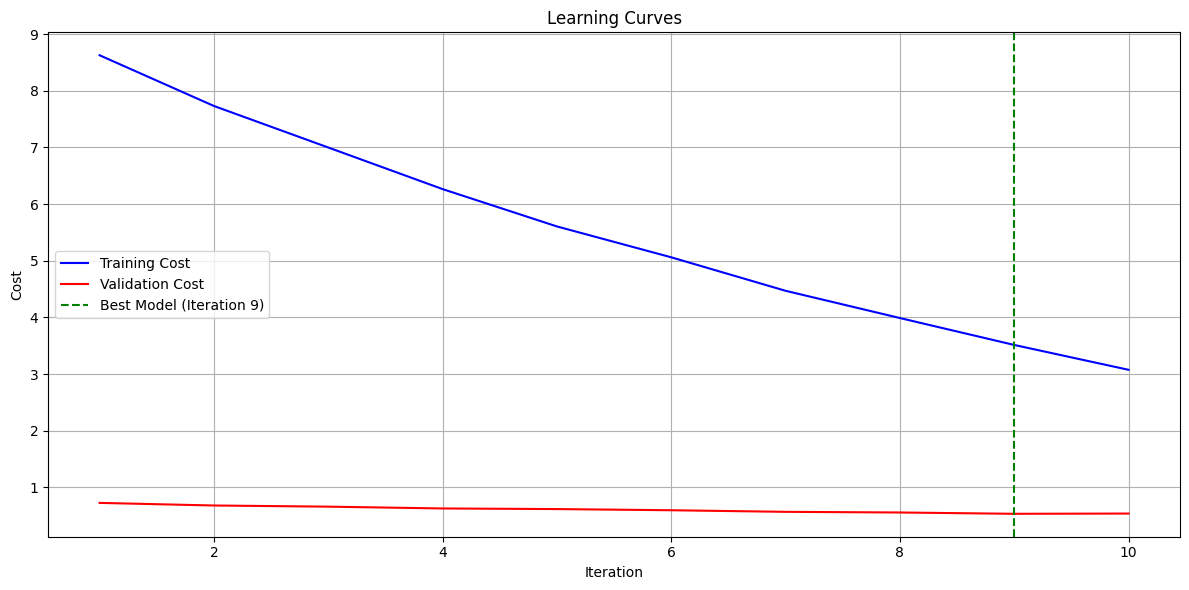


Plotting feature importance...


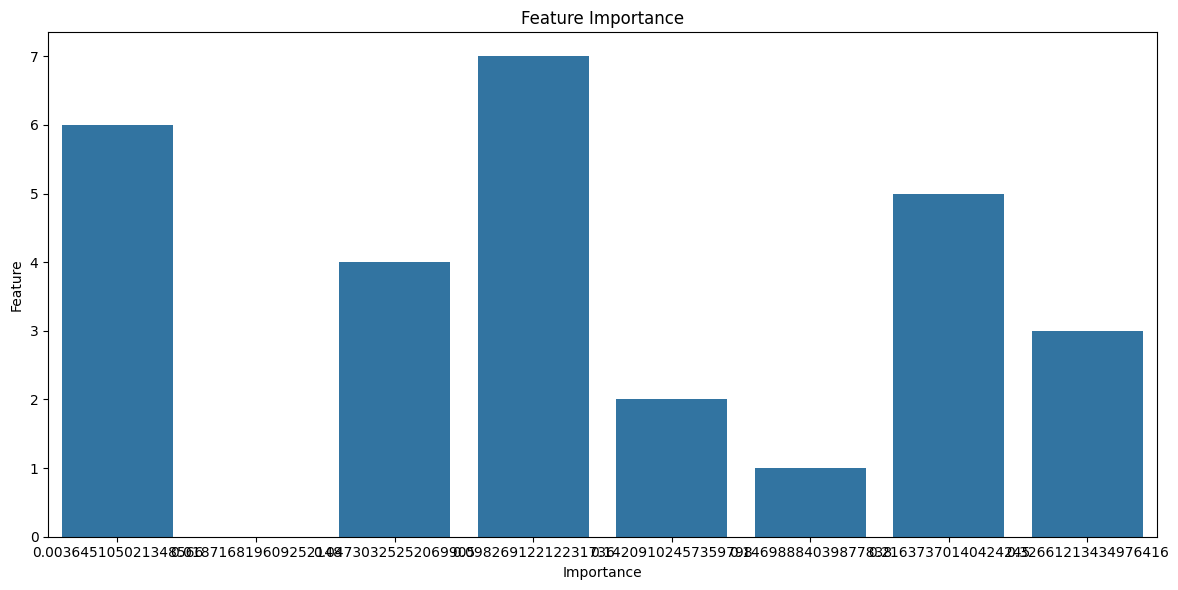


Plotting correlation matrix...


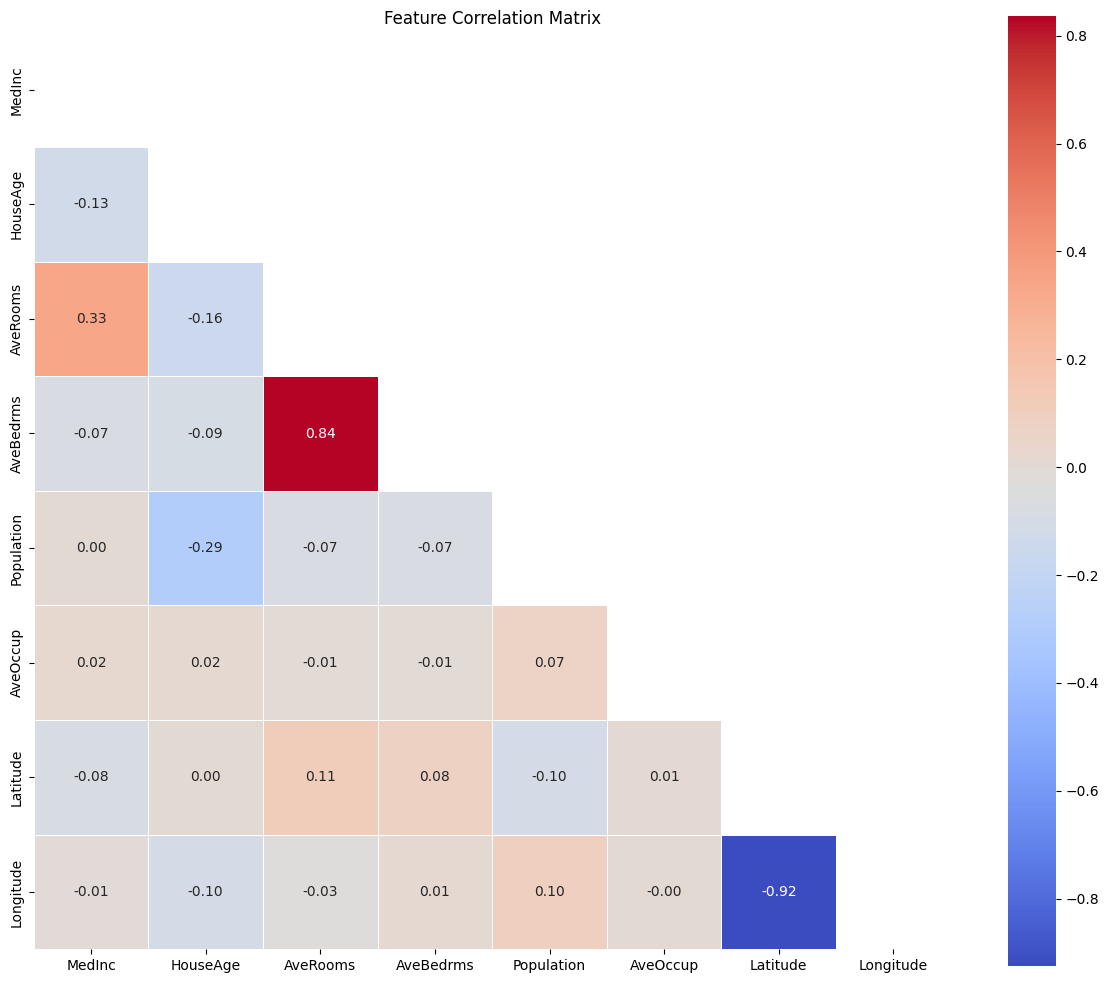


Select a feature to plot predictions against:
1. MedInc
2. HouseAge
3. AveRooms
4. AveBedrms
5. Population
6. AveOccup
7. Latitude
8. Longitude

Plotting predictions...


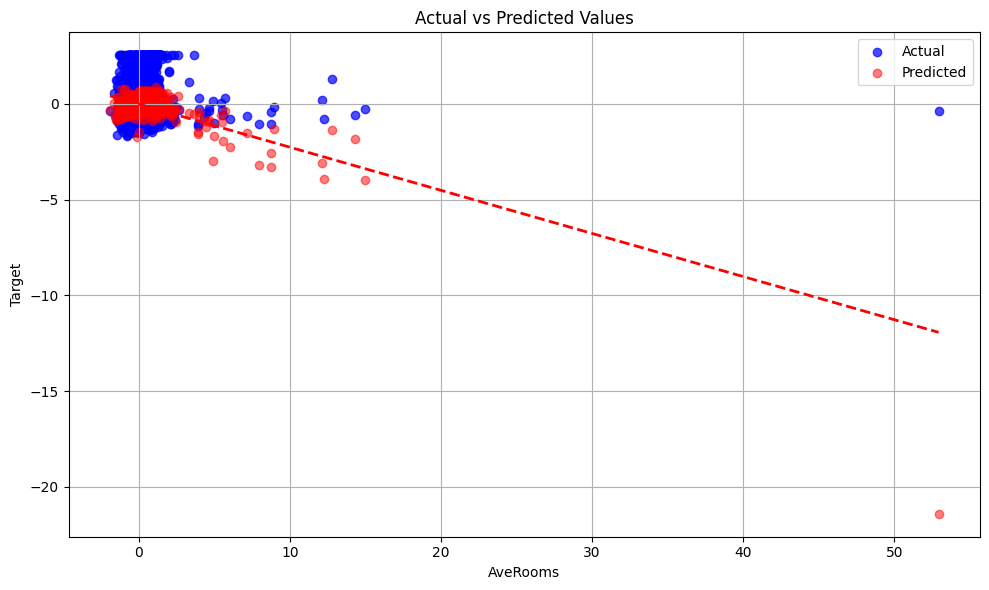


Plotting residuals...


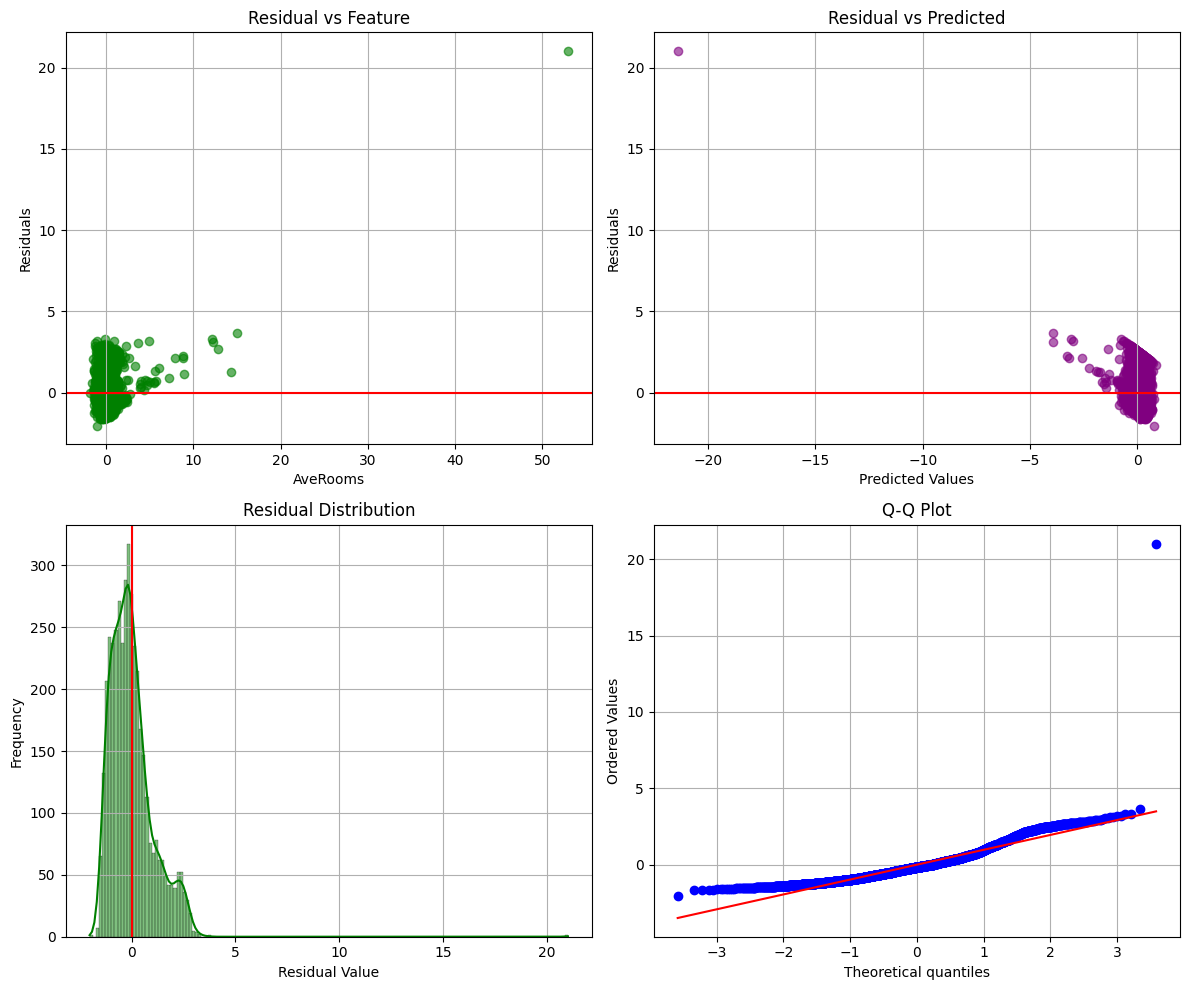

Model saved to lr.py
Model saved to lr.py

Execution completed.


In [6]:
if __name__ == "__main__":
    main()